In [42]:
import os
from collections import namedtuple

import numpy as np
from skimage.feature import peak_local_max
from scipy.stats import multivariate_normal
from scipy.optimize import leastsq
import progressbar
import matplotlib.pyplot as plt
import imageio

from utoolbox.container import Volume

### Environment presets

In [43]:
file_path = os.path.join(
    *["data", "20170831_SIM", "SI_b1a2DSIM_os", "summedWF", "RAWb1a2DSIM_os_ch0_stack0000_561nm.tif"]
)

In [44]:
kernel_size = 15
radius = (kernel_size-1) // 2

### Load data

In [45]:
raw = Volume(file_path)
print("shape={}".format(raw.shape))
print("dtype={}".format(raw.dtype))

shape=(101, 512, 512)
dtype=uint16


In [46]:
print("mean={:.2f}, sd={:.2f}".format(np.mean(raw), np.std(raw)))

mean=107.75, sd=19.62


### Find peaks

In [47]:
th = np.mean(raw) + 2*np.std(raw)
coords = peak_local_max(
    raw, exclude_border=radius, min_distance=2*kernel_size, threshold_abs=th
)

In [48]:
print("{} peaks found".format(len(coords)))

46 peaks found


### Isolate the patches

In [49]:
patches = np.zeros((len(coords), kernel_size, kernel_size, kernel_size), dtype=np.float32)

In [50]:
index = 0
bar = progressbar.ProgressBar()
for coord in bar(coords):
    x = coord[2]
    y = coord[1]
    z = coord[0]
    
    patches[index, ...] = raw[z-radius:z+radius+1, y-radius:y+radius+1, x-radius:x+radius+1]
    
    index += 1

100% (46 of 46) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


Save cropped patches.

In [51]:
patches_folder = os.path.join(os.path.dirname(file_path), "patches")
if not os.path.exists(patches_folder):
    os.makedirs(patches_folder)
    
index = 0
bar = progressbar.ProgressBar()
for patch in bar(patches):
    patches_path = os.path.join(patches_folder, "{}.tif".format(index))
    imageio.volwrite(patches_path, patch)
    index += 1

100% (46 of 46) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


### Preview selected beads

In [52]:
raw_xy = np.amax(raw, axis=0)

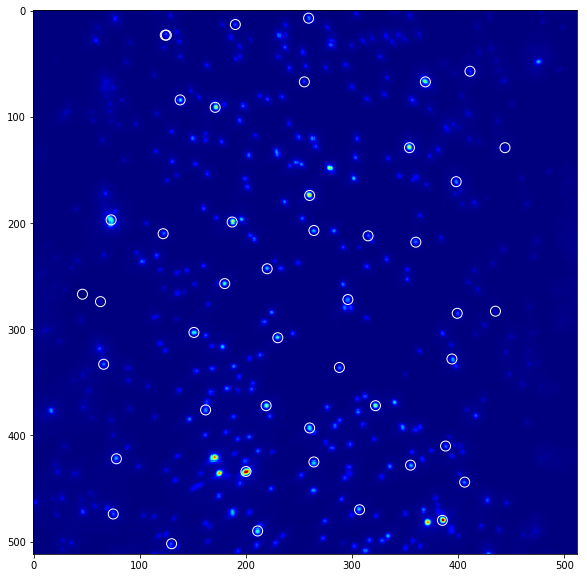

In [53]:
plt.figure(figsize=(10, 10))
plt.autoscale(enable=True, tight=True)

plt.imshow(raw_xy, cmap='jet')
plt.scatter(coords[:, 2], coords[:, 1], s=100, marker='o', facecolors='none', edgecolor='w')

### 3D fitting

In [54]:
Params = namedtuple('Params', 
    ['a',              # amplitude
     'cx', 'cy', 'cz', # centroid
     'wx', 'wy', 'wz'  # width
    ]
)

The fitting function.

In [93]:
def gaussian_3d(params):
    params = Params(*params)
    return lambda x, y, z: \
        params.a * np.exp(
            -( ((params.cx-x)/params.wx)**2 + 
               ((params.cy-y)/params.wz)**2 +
               ((params.cz-z)/params.wz)**2
             ) / 2
        )

In [94]:
def moments(data):
    s = data.sum()
    
    zi, yi, xi = np.indices(data.shape)
    cx = (xi*data).sum() / s
    cy = (yi*data).sum() / s
    cz = (zi*data).sum() / s
    
    t = data[int(cz), int(cy), :]
    wx = np.sqrt(np.abs((np.arange(t.size)-cx)**2 * t).sum() / t.sum())
    t = data[int(cz), :, int(cx)]
    wy = np.sqrt(np.abs((np.arange(t.size)-cy)**2 * t).sum() / t.sum())
    t = data[:, int(cy), int(cx)]
    wz = np.sqrt(np.abs((np.arange(t.size)-cz)**2 * t).sum() / t.sum())
    
    a = data.max()
    
    return Params(a, cx, cy, cz, wx, wy, wz)

In [117]:
def fit_gaussian_3d(data):
    """Returns fitting result of a 3D Gaussian distribution."""
    params = moments(data)
    err_func = lambda params: \
        np.ravel(gaussian_3d(params)(*np.indices(data.shape)) - data)
    optparams, success = leastsq(err_func, params)
    return optparams, success

In [118]:
n_failed = 0
bar = progressbar.ProgressBar()
for patch in bar(patches):
    optparams, is_success = fit_gaussian_3d(patch)
    if not is_success:
        n_failed += 1

print("failed to fit {} beads".format(n_failed))

100% (46 of 46) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01


failed to fit 0 beads


### Fitting test

In [114]:
i_patch = 42
data = patches[42, ...]

optparams, success = fit_gaussian_3d(data)
fit = gaussian_3d(optparams)

Params(*optparams)

success? 1


Params(a=327.71887560549993, cx=7.156935664145163, cy=6.704415939069287, cz=6.546984299571099, wx=6.082205527377312, wy=2.887064327311474, wz=6.048065305777078)

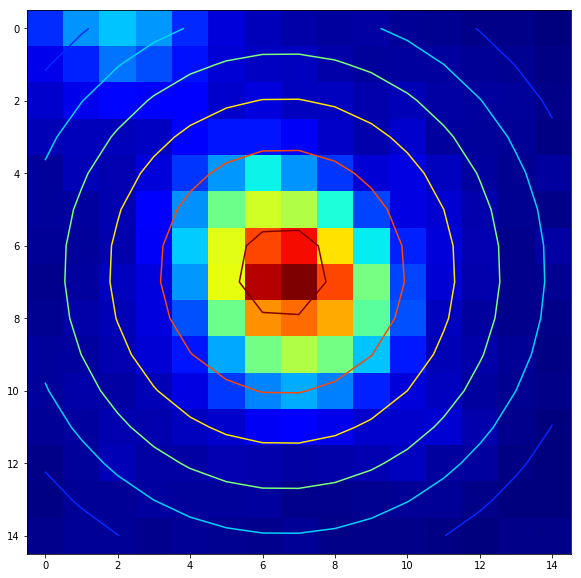

In [115]:
plt.figure(figsize=(10, 10))
plt.autoscale(enable=True, tight=True)

data_fit = fit(*np.indices(data.shape))
plt.imshow(np.amax(data, axis=0), cmap='jet')
plt.contour(np.amax(data_fit, axis=0), cmap='jet')